# Coding Requirements

1. Choose a dataset that has an outcome (predictive) variable.
2. Split that into train and test.
3. Define a metric to evaluate a machine learning model.
4. Build a pipeline using Airflow or MLflow or your platform pipeline to train a machine learning model using the train dataset (use AutoML to refine the category of algorithms).
5. Deploy the model for inference.
6. Set up model monitoring (if there is a monitoring dashboard show that).
7. Use the test data with the deployed model and validate the results (metric) and model monitoring.
8. Change atleast 2 feature values of the test dataset (you can put in random values or swap 2 features). <- Use dataset versioning for this part. Probably DVC
9. Use the "changed" test data with the deployed model and validate the results (metric) and verify observation with model monitoring.

# Presentation Requirements

Presentation in class that covers the above points with a video demo of #7 and #9.
The presentation PPT should include

1. EDA of your chosen dataset
2. Metric to evaluate the machine learning model
3. Pipeline you used to train the machine learning model
4. AutoML results and the chosen algorithm
5. Model monitoring
6. The "change" in the test dataset
7. Github link that contains the project code

Clearly outline which member did which part of the project.

Data Available at: https://www.kaggle.com/datasets/muhammadroshaanriaz/time-wasters-on-social-media/data

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import kagglehub
import shutil
import os
import glob
import pandas as pd
import numpy as np

os.makedirs('./data', exist_ok=True)
path = kagglehub.dataset_download("muhammadroshaanriaz/time-wasters-on-social-media")

# Print the download path and current working directory
print("Downloaded path:", path)
print("Current working directory:", os.getcwd())

# Move all files found in the downloaded path to ./data
for file in glob.glob(os.path.join(path, '**', '*.*'), recursive=True):
    if os.path.isfile(file):
        shutil.move(file, './data')

# List the files in ./data to see what CSVs are actually there
files_in_data = glob.glob('./data/*')
print("Files in data directory:", files_in_data)

# Try loading any CSV found
csv_files = [f for f in files_in_data if f.lower().endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV files found in ./data")

df = pd.read_csv(csv_files[0])
if 'UserID' in df.columns:
    df.drop('UserID', axis=1, inplace=True)

df.head()

100%|██████████| 36.0k/36.0k [00:00<00:00, 6.62MB/s]

Extracting files...
Downloaded path: /Users/zfara/.cache/kagglehub/datasets/muhammadroshaanriaz/time-wasters-on-social-media/versions/1
Current working directory: /Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP
Files in data directory: ['./data/Time-Wasters on Social Media.csv']


,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,...,ProductivityLoss,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Self Control,Addiction Level,CurrentActivity,ConnectionType
0,56,Male,Pakistan,82812,True,True,Engineer,Rural,Instagram,80,...,3,7,Procrastination,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
1,46,Female,Mexico,27999,False,True,Artist,Urban,Instagram,228,...,5,5,Habit,Computer,Android,5:00 PM,7,3,At school,Wi-Fi
2,32,Female,United States,42436,False,True,Engineer,Rural,Facebook,30,...,6,4,Entertainment,Tablet,Android,2:00 PM,8,2,At home,Mobile Data
3,60,Male,Barzil,62963,True,False,Waiting staff,Rural,YouTube,101,...,3,7,Habit,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
4,25,Male,Pakistan,22096,False,True,Manager,Urban,TikTok,136,...,8,2,Boredom,Smartphone,iOS,8:00 AM,10,0,At home,Mobile Data


# EDA

<Axes: >

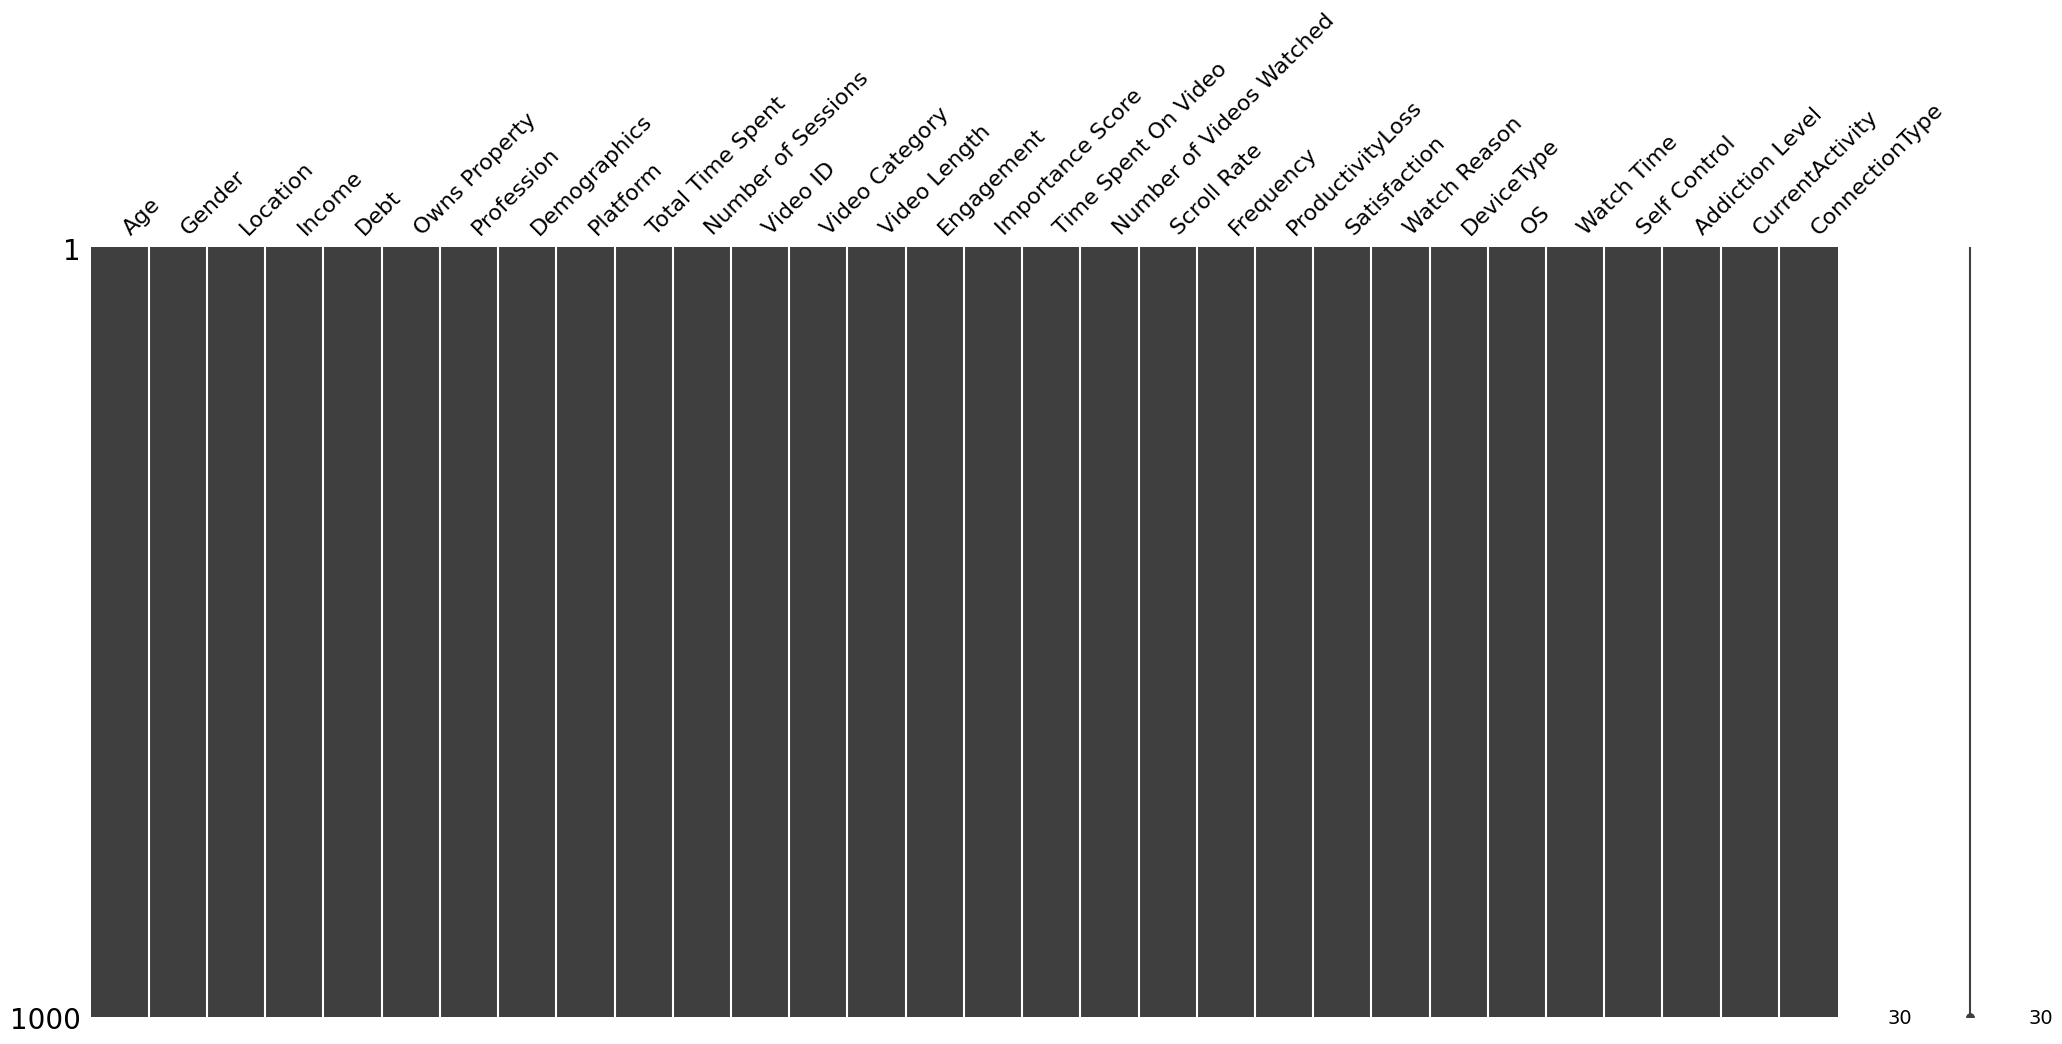

In [4]:
import missingno as msno

# Visualize the missing values in the dataframe
msno.matrix(df)

# Preprocessing

In [5]:
def good_one_hot(X, n_unique):

    X_copy = X.copy()  
    
    for col in X_copy.select_dtypes(include=['object', 'category']).columns:
        top_categories = X_copy[col].value_counts().nlargest(n_unique).index
        X_copy[col] = X_copy[col].where(X_copy[col].isin(top_categories), other="Other")
    
    X_encoded = pd.get_dummies(X_copy, columns=X_copy.select_dtypes(include=['object', 'category']).columns)
    
    return X_encoded

def add_interaction_terms(X):
    from itertools import combinations
    interaction_terms = pd.DataFrame(index=X.index)
    continuous_columns = X.select_dtypes(include=[np.number]).columns
    for col1, col2 in combinations(continuous_columns, 2):
        interaction_term_name = f"{col1}_x_{col2}"
        interaction_terms[interaction_term_name] = X[col1] * X[col2]
    return pd.concat([X, interaction_terms], axis=1)

df = good_one_hot(df, 100)

y = df['ProductivityLoss']
y = pd.DataFrame({"Brain Rot": y})
y['Brain Rot'] = y['Brain Rot'].apply(lambda x: 0 if x < 5 else 1)
# x = df.drop(columns=['ProductivityLoss', 'Satisfaction', 'Addiction Level', 'Self Control'])
x = df.drop(columns=['ProductivityLoss', 'Satisfaction', 'Addiction Level', 'Self Control'])
x = add_interaction_terms(x)

features = x.copy()
target = y.copy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Add these to the data folder for the AutoML portion
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)
train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

# AutoML

Using AutoML to define what are some good model categories to try out

In [59]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(port = 54325, nthreads = -1, max_mem_size = "6g")
train = h2o.import_file("data/train.csv")
test = h2o.import_file("data/test.csv")
x = train.columns
y = "Brain Rot"
if y in x:
    x.remove(y)
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
aml = H2OAutoML(max_models=100, max_runtime_secs=60, seed=1) 
aml.train(x=x, y=y, training_frame=train)
lb = aml.leaderboard
lb.head(rows=lb.nrows)

Checking whether there is an H2O instance running at http://localhost:54325. connected.


H2O_cluster_uptime:,14 hours 47 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_zfara_e6df1c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.814 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:07:16.932: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_11_20241125_150716_model_7,0.885002,0.370097,0.921678,0.139316,0.33215,0.110324
GBM_4_AutoML_11_20241125_150716,0.883429,0.380401,0.921623,0.144942,0.338009,0.11425
GBM_grid_1_AutoML_11_20241125_150716_model_3,0.883237,0.382684,0.920805,0.153186,0.34104,0.116309
GBM_grid_1_AutoML_11_20241125_150716_model_2,0.881441,0.37251,0.910989,0.143995,0.333602,0.111291
GBM_5_AutoML_11_20241125_150716,0.880985,0.379166,0.912093,0.151181,0.335651,0.112662
GBM_grid_1_AutoML_11_20241125_150716_model_1,0.880884,0.391266,0.920705,0.166778,0.345452,0.119337
GBM_2_AutoML_11_20241125_150716,0.878753,0.38229,0.916638,0.141154,0.338524,0.114599
GBM_grid_1_AutoML_11_20241125_150716_model_5,0.877329,0.380886,0.916548,0.142101,0.337018,0.113581
GBM_3_AutoML_11_20241125_150716,0.876908,0.386688,0.91774,0.148451,0.341663,0.116733
GLM_1_AutoML_11_20241125_150716,0.875599,0.396389,0.90708,0.166778,0.346113,0.119794


In [60]:
# Display the top 5 models from the H2O AutoML leaderboard
lb.head(rows=25)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_11_20241125_150716_model_7,0.885002,0.370097,0.921678,0.139316,0.33215,0.110324
GBM_4_AutoML_11_20241125_150716,0.883429,0.380401,0.921623,0.144942,0.338009,0.11425
GBM_grid_1_AutoML_11_20241125_150716_model_3,0.883237,0.382684,0.920805,0.153186,0.34104,0.116309
GBM_grid_1_AutoML_11_20241125_150716_model_2,0.881441,0.37251,0.910989,0.143995,0.333602,0.111291
GBM_5_AutoML_11_20241125_150716,0.880985,0.379166,0.912093,0.151181,0.335651,0.112662
GBM_grid_1_AutoML_11_20241125_150716_model_1,0.880884,0.391266,0.920705,0.166778,0.345452,0.119337
GBM_2_AutoML_11_20241125_150716,0.878753,0.38229,0.916638,0.141154,0.338524,0.114599
GBM_grid_1_AutoML_11_20241125_150716_model_5,0.877329,0.380886,0.916548,0.142101,0.337018,0.113581
GBM_3_AutoML_11_20241125_150716,0.876908,0.386688,0.91774,0.148451,0.341663,0.116733
GLM_1_AutoML_11_20241125_150716,0.875599,0.396389,0.90708,0.166778,0.346113,0.119794


Now it seems the main model architectures are 
1. Gradient Boosting Trees
2. Deep Learning
3. Random Forest

# MLFlow
Now let's do the MLFlow sections

In [6]:
# Required imports
import seaborn as sns
import shap
import mlflow
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

mlflow.set_experiment("Final Classification Experiment")

# Function to evaluate classification metrics
def classification_metrics(y_true, y_pred):
    
    y_pred = (y_pred > .5).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, roc_auc

global scaler

# Flexible experiment runner
def run_experiment(train, test, model, hyperparams=None):
    try:
        # Split input into features and target
        X_train, y_train = train
        X_test, y_test = test
        
        # Preprocessing
        scaler = StandardScaler()
        continuous_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
        X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
        X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

        # Add interaction terms (if applicable)
        X_train = X_train.apply(pd.to_numeric, errors='coerce')
        X_test = X_test.apply(pd.to_numeric, errors='coerce')

        # Configure model
        if hyperparams:
            model.set_params(**hyperparams)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Metrics
        metrics_train = classification_metrics(y_train, y_pred_train)
        metrics_test = classification_metrics(y_test, y_pred_test)
        
        input_example = X_test.iloc[:5]

        # Log parameters and metrics to MLflow
        mlflow.start_run()
        mlflow.log_param("model", type(model).__name__)
        if hyperparams:
            mlflow.log_params(hyperparams)
        mlflow.log_metric("accuracy_train", metrics_train[0])
        mlflow.log_metric("accuracy_test", metrics_test[0])
        mlflow.log_metric("precision_train", metrics_train[1])
        mlflow.log_metric("precision_test", metrics_test[1])
        mlflow.log_metric("recall_train", metrics_train[2])
        mlflow.log_metric("recall_test", metrics_test[2])
        mlflow.log_metric("f1_train", metrics_train[3])
        mlflow.log_metric("f1_test", metrics_test[3])
        mlflow.log_metric("roc_auc_train", metrics_train[4])
        mlflow.log_metric("roc_auc_test", metrics_test[4])
        
        if isinstance(model, RandomForestClassifier):
            mlflow.sklearn.log_model(model, "model", input_example=input_example)
        elif isinstance(model, XGBClassifier):
            mlflow.xgboost.log_model(model, "model", input_example=input_example)
        elif isinstance(model, MLPClassifier):
            mlflow.sklearn.log_model(model, "model", input_example=input_example)
        else:
            print("Model not supported for logging")

        # Model-specific visualizations
        generate_model_explanations(model, X_train, X_test, y_test)

        # Confusion matrix
        generate_confusion_matrix(y_test, y_pred_test)

        # Precision-Recall curve and ROC curve
        generate_pr_roc_curves(model, X_test, y_test)

    except Exception as e:
        print(f"An error occurred: {e}")
        raise e

    finally:
        mlflow.end_run()
        return scaler


def generate_model_explanations(model, X_train, X_test, y_test):
    if isinstance(model, (RandomForestClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
        mlflow.log_figure(plt.gcf(), "shap_summary_plot.png")
    elif isinstance(model, MLPClassifier):
        background = X_train.sample(n=100, random_state=0)
        def model_predict(X): return model.predict(X)
        explainer = shap.KernelExplainer(model_predict, background)
        shap_values = explainer.shap_values(X_test, nsamples=100)
        shap.summary_plot(shap_values, X_test)
        mlflow.log_figure(plt.gcf(), "shap_summary_plot.png")
    else:
        explainer = shap.Explainer(model.predict, X_train)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
        mlflow.log_figure(plt.gcf(), "shap_summary_plot.png")


def generate_confusion_matrix(y_test, y_pred_test):
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    mlflow.log_figure(plt.gcf(), "confusion_matrix.png")


def generate_pr_roc_curves(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    mlflow.log_figure(plt.gcf(), "precision_recall_curve.png")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    mlflow.log_figure(plt.gcf(), "roc_curve.png")

# Get our two different data versioning test sets

In [11]:
import subprocess

def run_command(command):
    result = subprocess.run(command, capture_output=True, text=True, check=True)
    print(result.stdout)
    

def checkout_dataset_version(version:str) -> None:
    """
    This function is meant to checkout a certain version of the dataset using git and dvc
    """
    assert version in ['v1', 'v2']    

    version_to_commit = {'v1':'02921be453d84a8b35f9eb49ec56b8d7e319173c',
                         'v2':'caeb595129d0233402cd5079ab9e7dbede63688f'}
    
    checkout_hash = version_to_commit[version]
    
    run_command(["git", "checkout", checkout_hash])
    run_command(["dvc", "checkout"])
    

## At this point I added dataset v1 do DVC using the command line

In [7]:
x_test['Age']

521    25
737    38
740    34
660    38
411    61
       ..
408    54
332    34
208    40
613    22
78     40
Name: Age, Length: 200, dtype: int64

In [8]:
# Make data version 2 in DVC

# Let's completely swap the age and demographic variables for just the testing set
x_test['Age'] = np.random.permutation(x_test['Age'].values)
x_test['Demographics_Urban'] = np.random.permutation(x_test['Demographics_Urban'].values)

train_to_commit = pd.concat([x_train, y_train], axis=1)
test_to_commit = pd.concat([x_test, y_test], axis=1)
train_to_commit.to_csv('./data/train.csv', index=False)
test_to_commit.to_csv('./data/test.csv', index=False)


In [9]:
test_to_commit['Age']

521    59
737    41
740    31
660    59
411    28
       ..
408    52
332    56
208    33
613    38
78     58
Name: Age, Length: 200, dtype: int64

## At this point I added data version 2 to DVC

In [12]:
def load_data_version(version:str) -> pd.DataFrame:
    checkout_dataset_version(version)
    train = pd.read_csv('./data/train.csv')
    test = pd.read_csv('./data/test.csv')
    return train, test


In [33]:
train, test = load_data_version('v2')
test['Age']


0      59
1      41
2      31
3      59
4      28
       ..
195    52
196    56
197    33
198    38
199    58
Name: Age, Length: 200, dtype: int64

In [34]:
train, test = load_data_version('v1')
test['Age']
# Ad you can see they are different so we can saved the different data versions in DVC


M       data/



0      25
1      38
2      34
3      38
4      61
       ..
195    54
196    34
197    40
198    22
199    40
Name: Age, Length: 200, dtype: int64

In [20]:
x_train = train.drop(columns=['Brain Rot'])
y_train = train['Brain Rot']
x_test = test.drop(columns=['Brain Rot'])
y_test = test['Brain Rot']

training_data = (x_train, y_train)
testing_data = (x_test, y_test)

Iteration 1/2
Hyperparameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.5, 'min_child_weight': 5, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'scale_pos_weight': 0.5151515151515151}


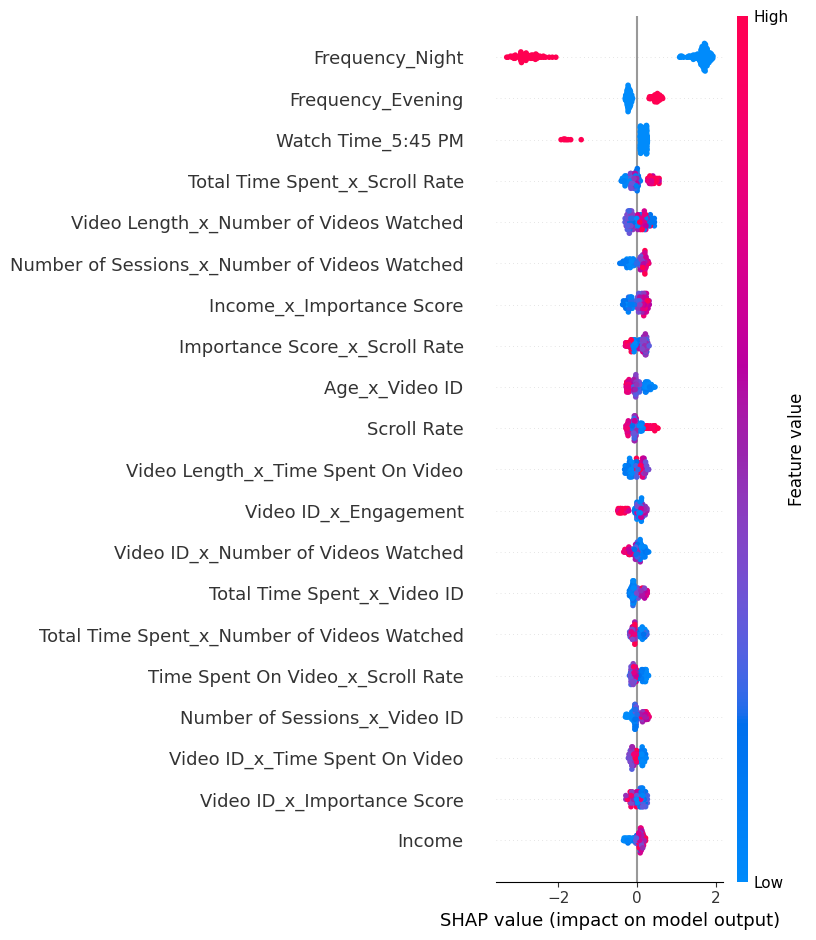

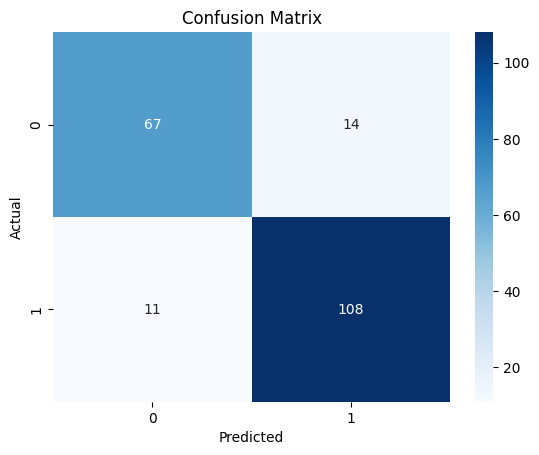

<Figure size 640x480 with 0 Axes>

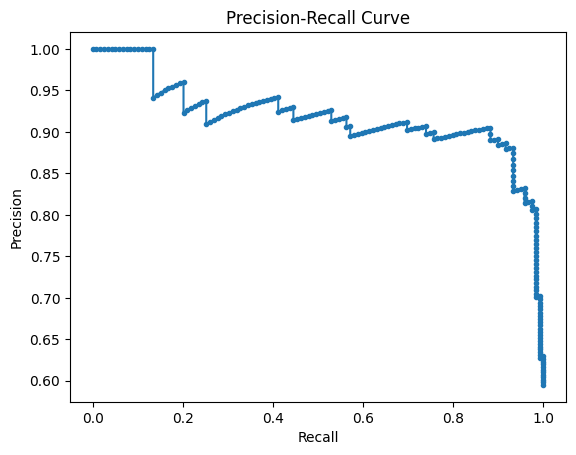

<Figure size 640x480 with 0 Axes>

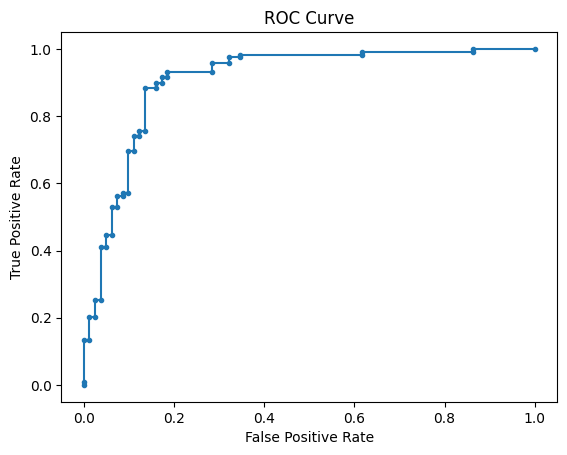

Iteration 2/2
Hyperparameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'scale_pos_weight': 0.5151515151515151}


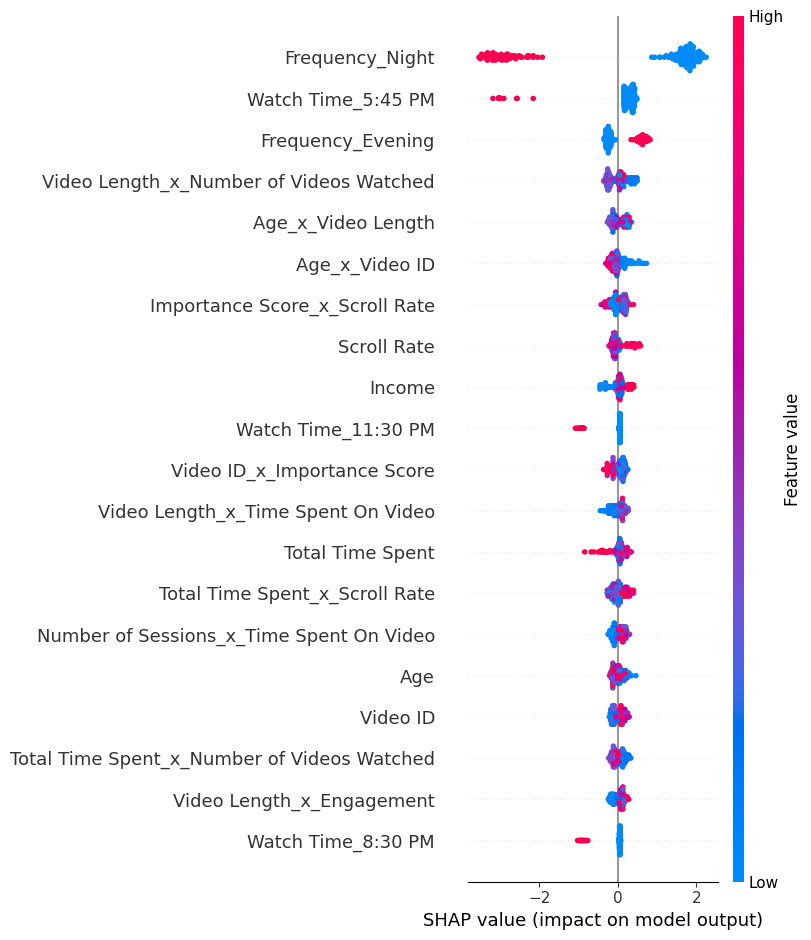

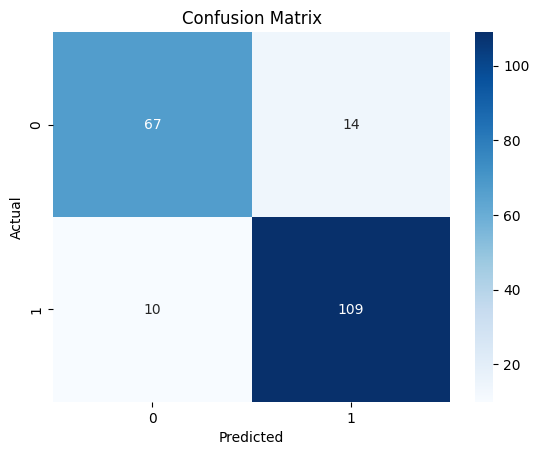

<Figure size 640x480 with 0 Axes>

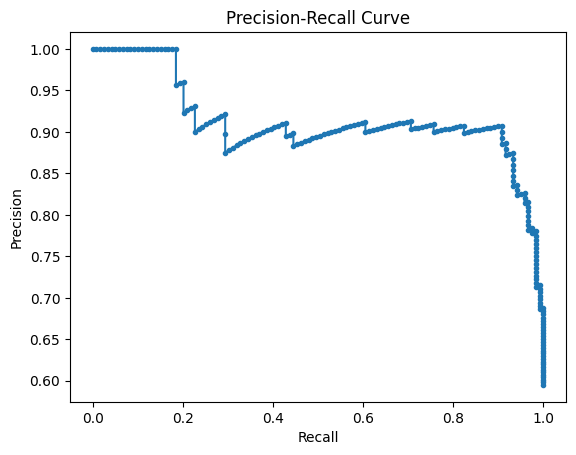

<Figure size 640x480 with 0 Axes>

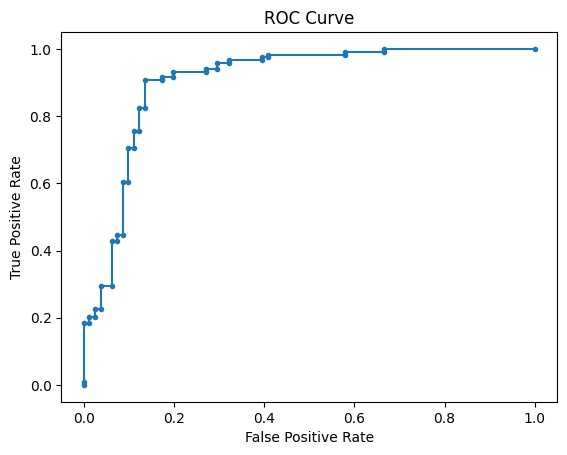

<Figure size 640x480 with 0 Axes>

In [25]:
from xgboost import XGBClassifier

neg_class_count = (y_train == 0).sum()  # Count of negative samples
pos_class_count = (y_train == 1).sum()  # Count of positive samples
scale_pos_weight = float(neg_class_count / pos_class_count)

param_grid = {
    'n_estimators': list(range(50, 1000, 50)),  # Number of trees
    'max_depth': [2, 3, 5, 7, 9, 12],  # Maximum depth of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns for each tree
    'gamma': [0, 0.1, 0.3, 0.5],  # Minimum loss reduction for further tree split
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) needed in a child
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2, 5],  # L2 regularization term on weights
    'scale_pos_weight': [scale_pos_weight, None]  # Dynamically computed weight
}

xgb_model = XGBClassifier(random_state=0)

num_iterations = 2
for i in range(num_iterations):
    # Randomly sample hyperparameters
    hyperparams = {k: np.random.choice(v) for k, v in param_grid.items()}
    print(f"Iteration {i+1}/{num_iterations}")
    print("Hyperparameters:", hyperparams)
    scaler = run_experiment(train=training_data, test=testing_data, model=xgb_model, hyperparams=hyperparams)


Iteration 1/5
Hyperparameters: {'n_estimators': 750, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:01:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Mis

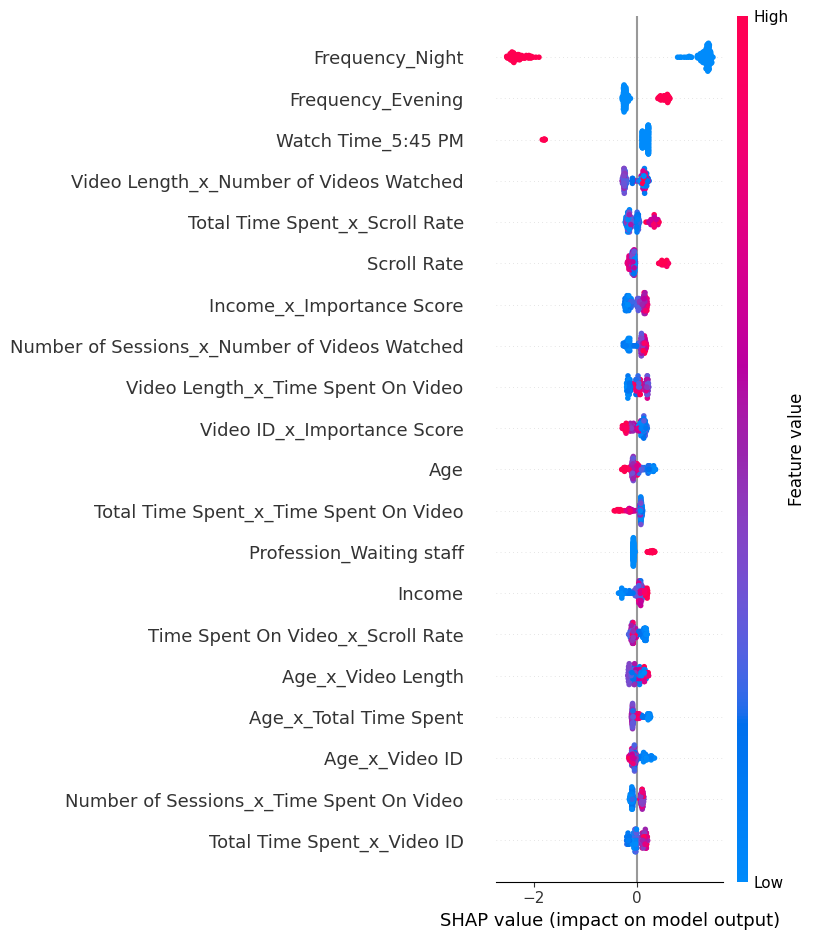

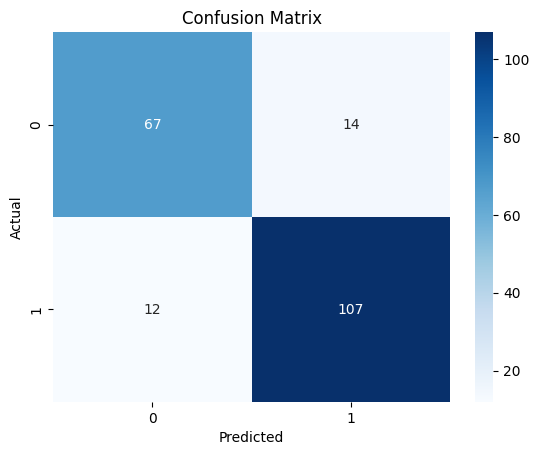

<Figure size 640x480 with 0 Axes>

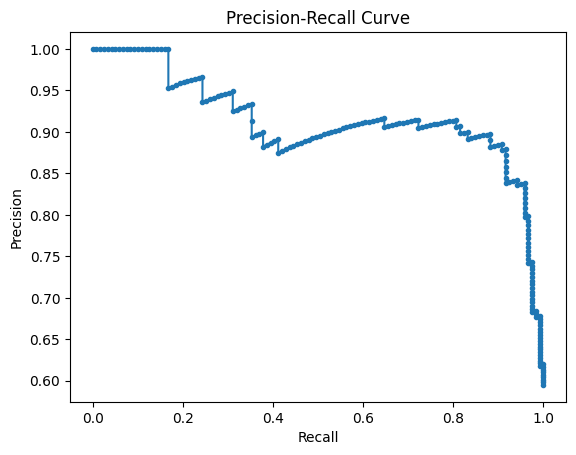

<Figure size 640x480 with 0 Axes>

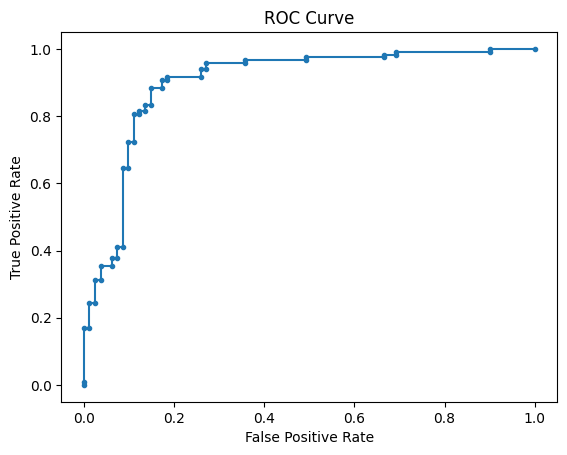

Iteration 2/5
Hyperparameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:01:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling I

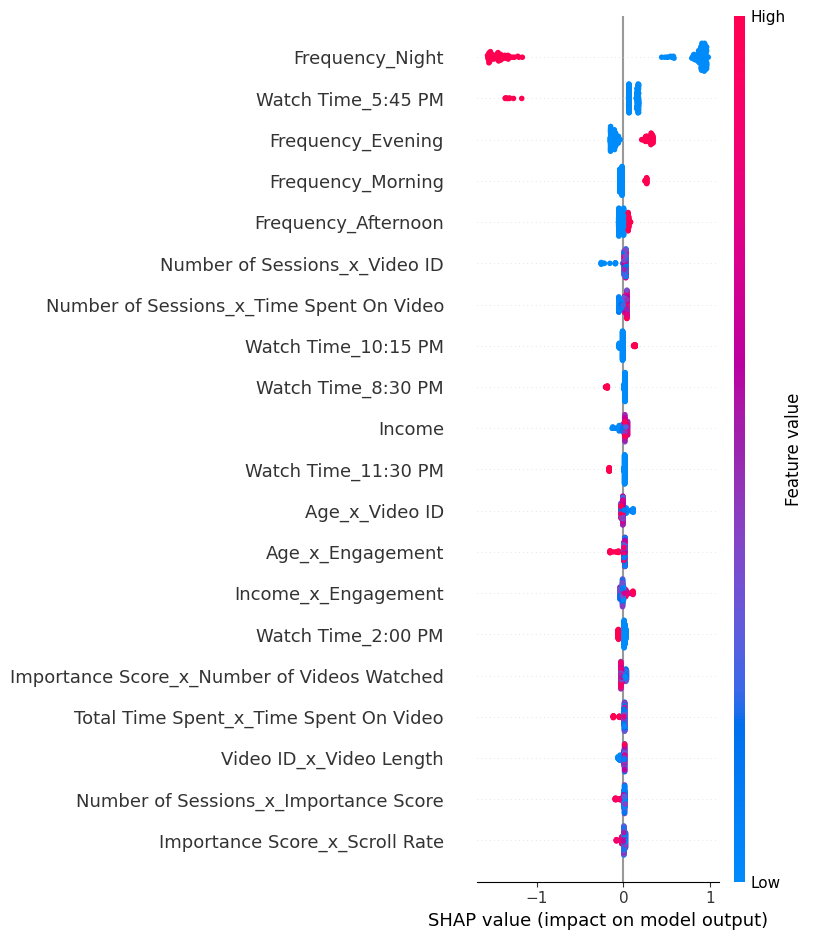

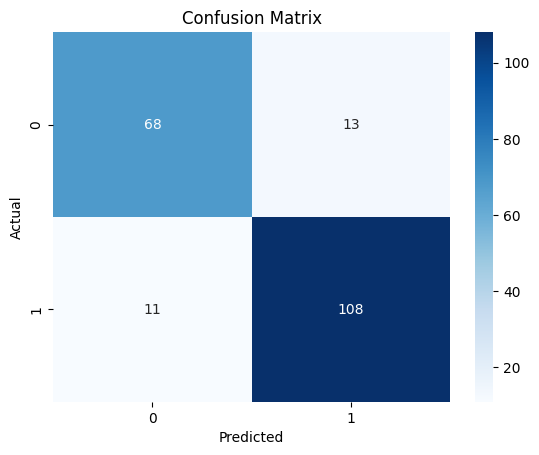

<Figure size 640x480 with 0 Axes>

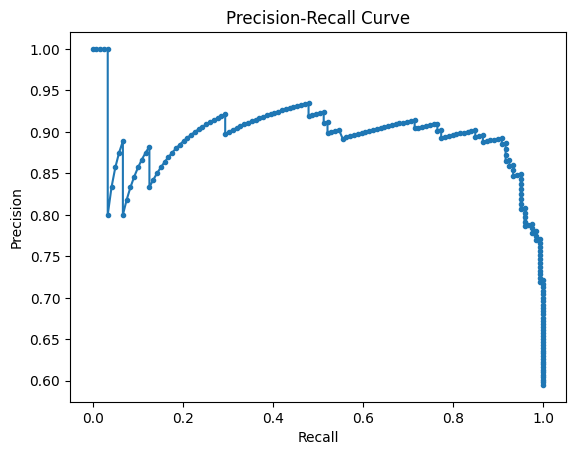

<Figure size 640x480 with 0 Axes>

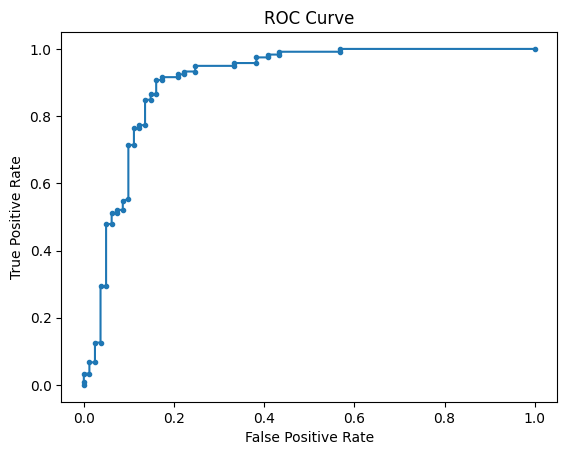

Iteration 3/5
Hyperparameters: {'n_estimators': 150, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:01:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling I

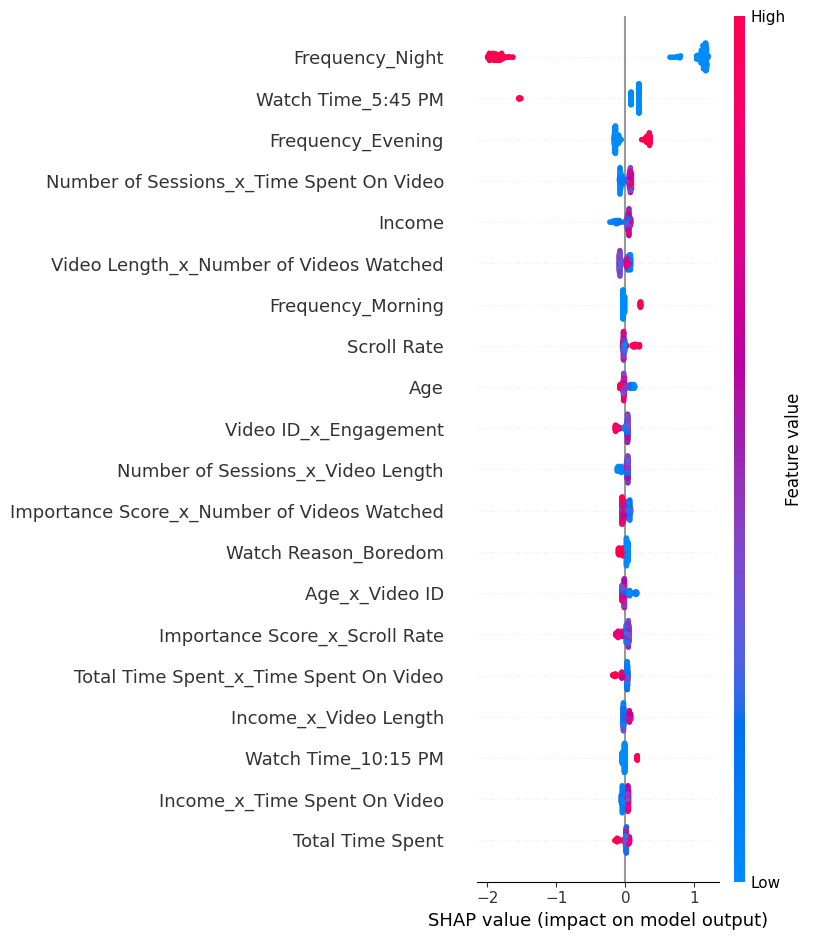

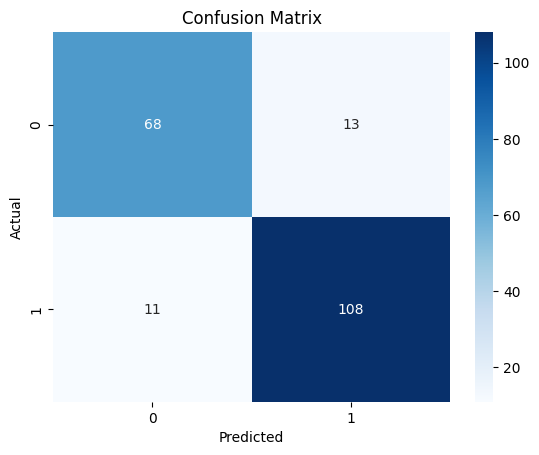

<Figure size 640x480 with 0 Axes>

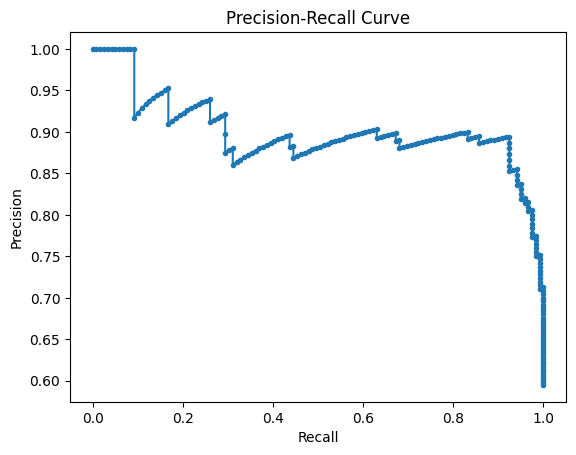

<Figure size 640x480 with 0 Axes>

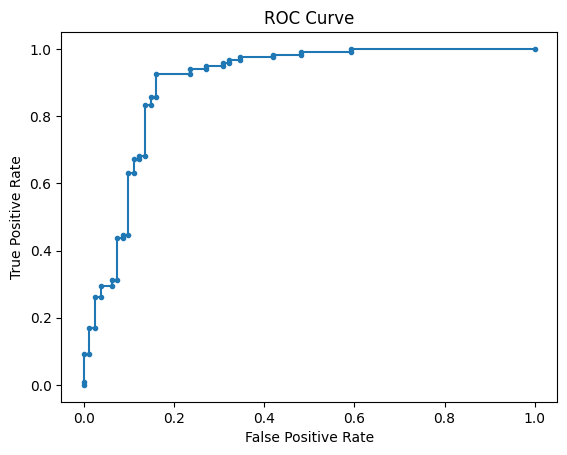

Iteration 4/5
Hyperparameters: {'n_estimators': 950, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:01:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling I

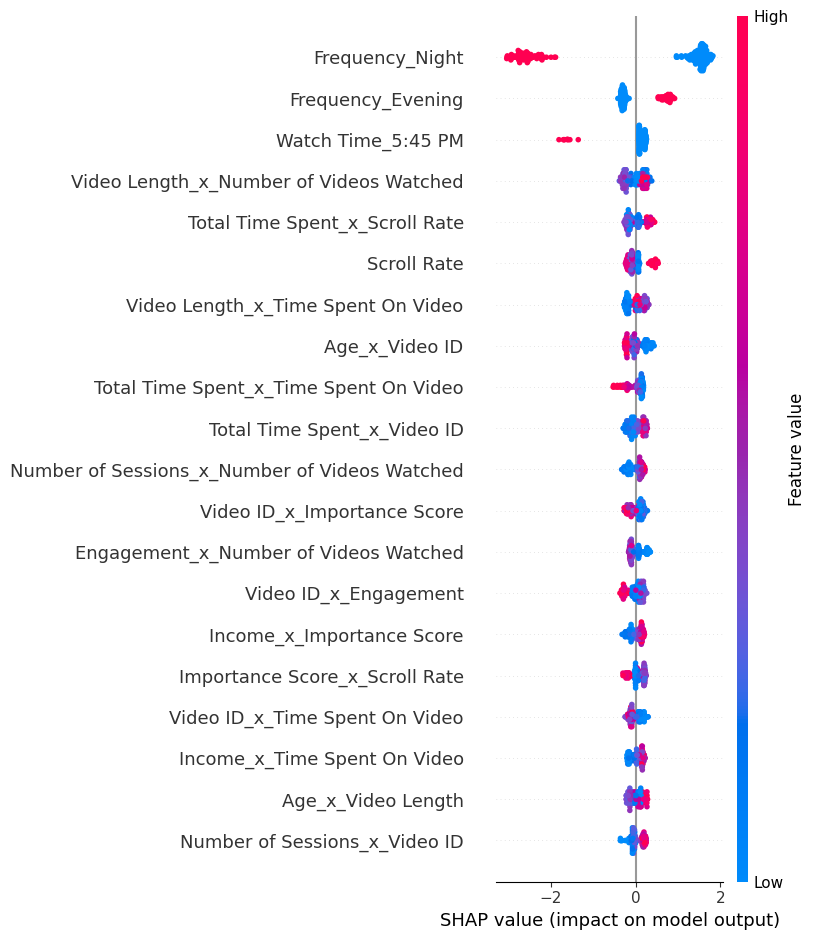

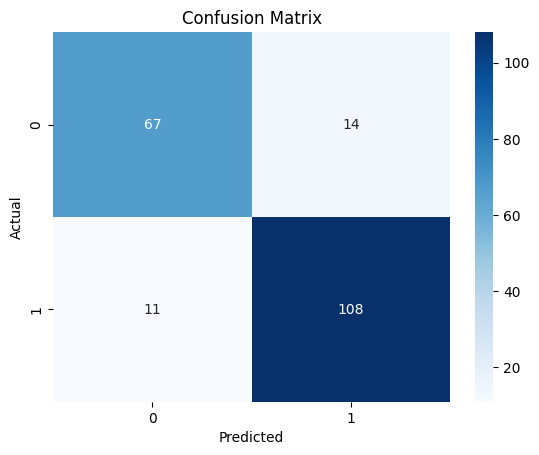

<Figure size 640x480 with 0 Axes>

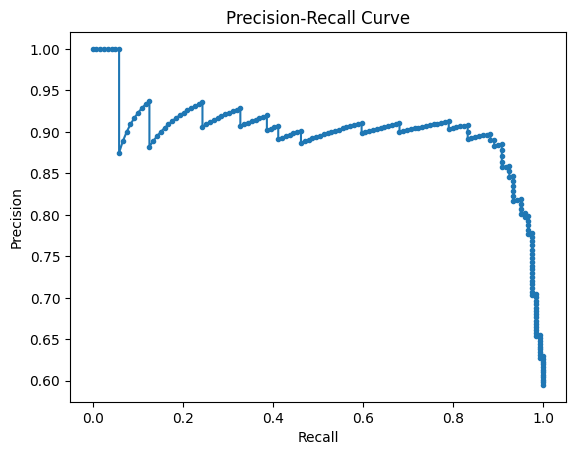

<Figure size 640x480 with 0 Axes>

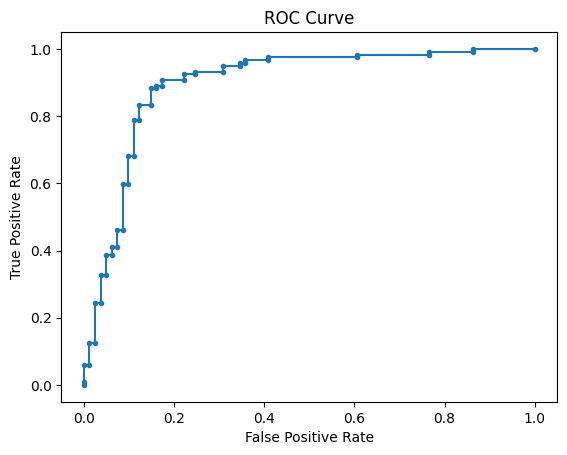

Iteration 5/5
Hyperparameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:01:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Mis

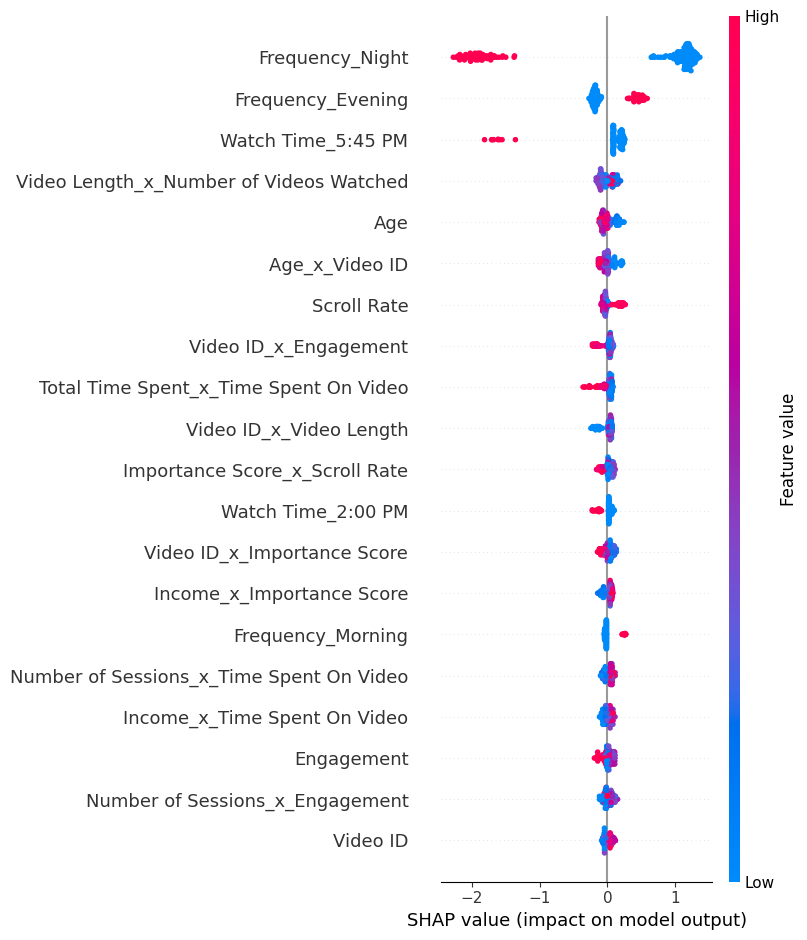

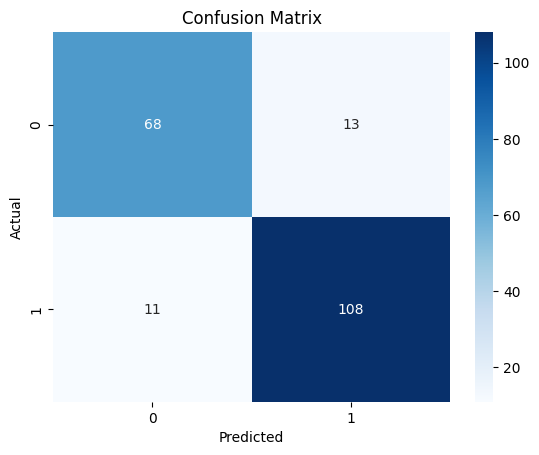

<Figure size 640x480 with 0 Axes>

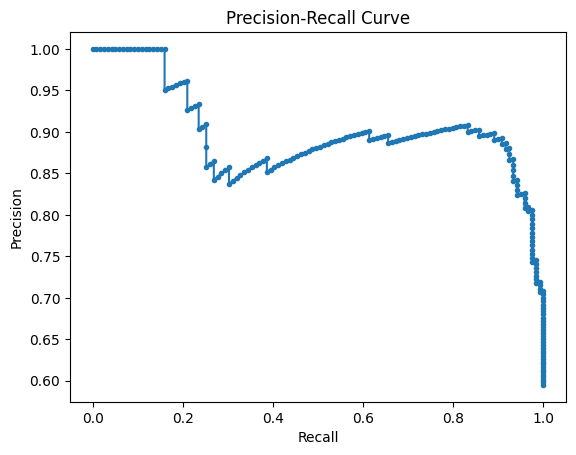

<Figure size 640x480 with 0 Axes>

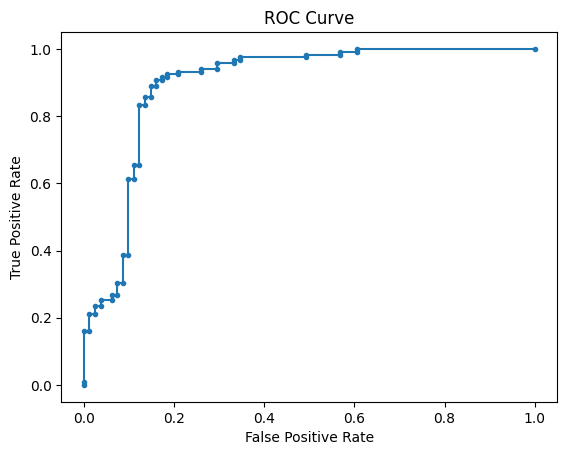

<Figure size 640x480 with 0 Axes>

In [ ]:
rf_model = RandomForestClassifier(random_state=0)

param_grid = {
    'n_estimators': list(range(50, 1000, 50)),  # Number of trees
    'max_depth': [2, 3, 5, 7, 9, 12],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

num_iterations = 5
for i in range(num_iterations):
    # Randomly sample hyperparameters
    hyperparams = {k: np.random.choice(v) for k, v in param_grid.items()}
    print(f"Iteration {i+1}/{num_iterations}")
    print("Hyperparameters:", hyperparams)
    scaler = run_experiment(train=training_data, test=testing_data, model=rf_model, hyperparams=hyperparams)


Iteration 1/2
Hyperparameters: {'hidden_layer_sizes': (100, 100), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate_init': 0.05757142857142858, 'max_iter': 400}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  0%|          | 0/200 [00:00<?, ?it/s]/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  0%|          | 1/200 [00:00<01:11,  2.78it/s]/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier w

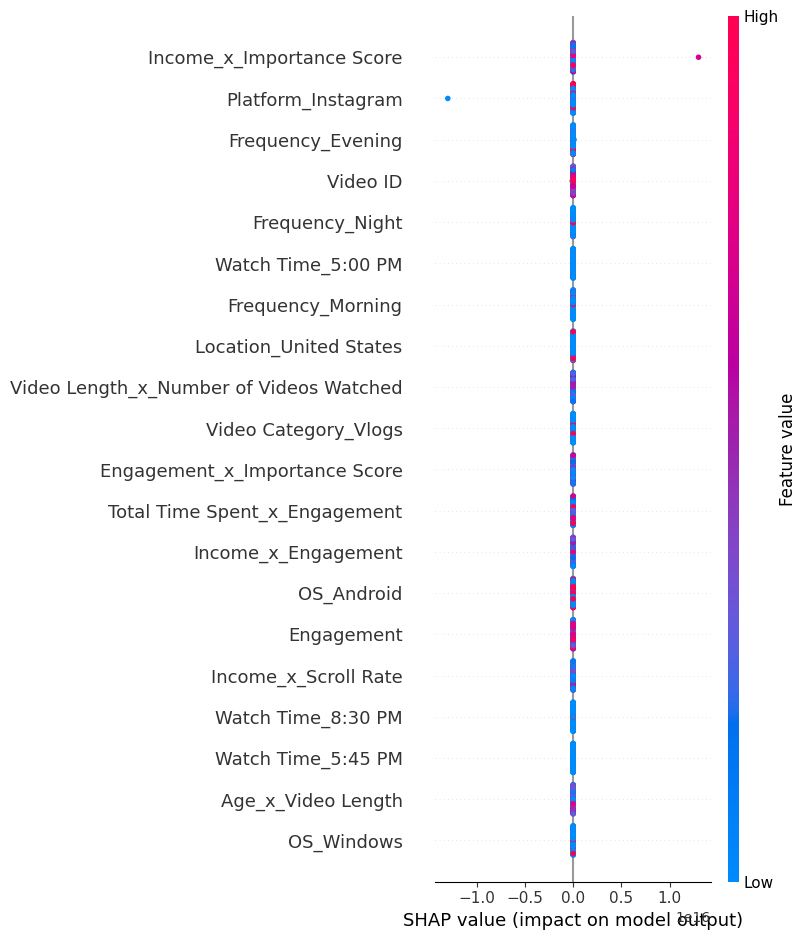

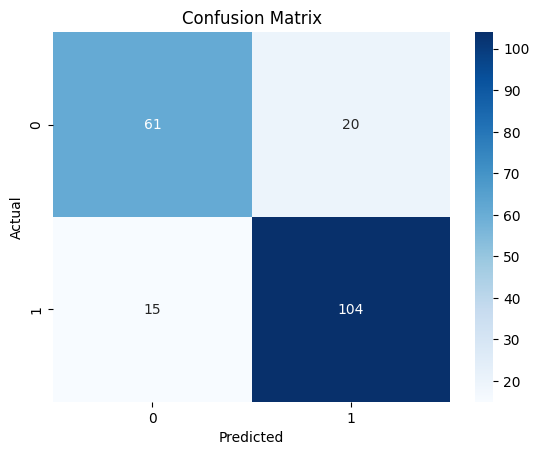

<Figure size 640x480 with 0 Axes>

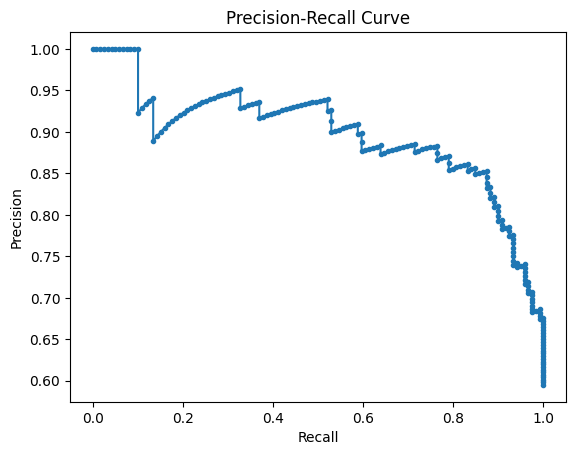

<Figure size 640x480 with 0 Axes>

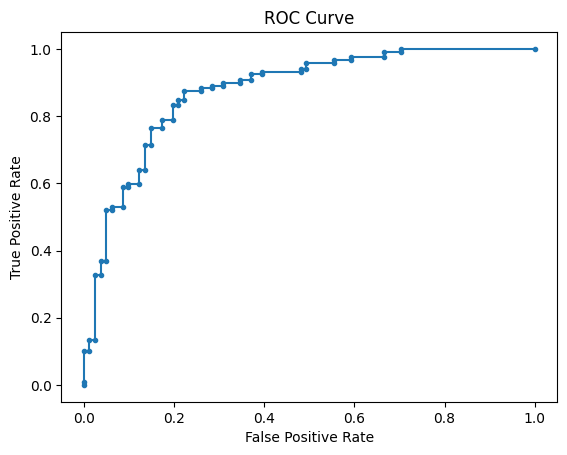

Iteration 2/2
Hyperparameters: {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate_init': 0.0959591836734694, 'max_iter': 300}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  0%|          | 0/200 [00:00<?, ?it/s]/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  0%|          | 1/200 [00:00<01:18,  2.52it/s]/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier w

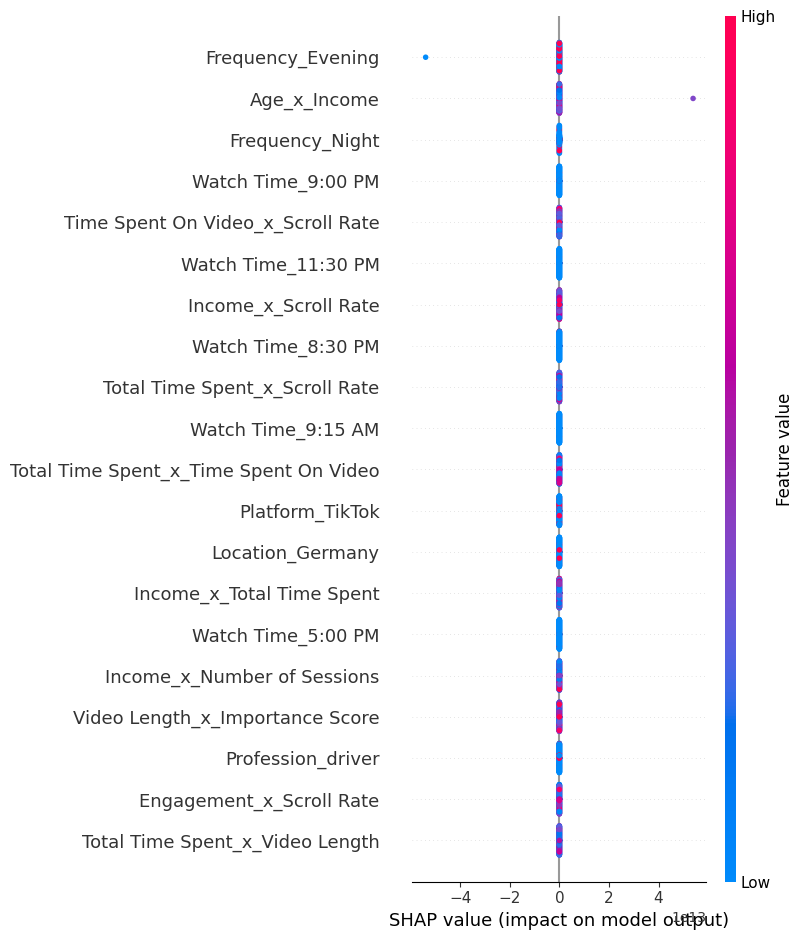

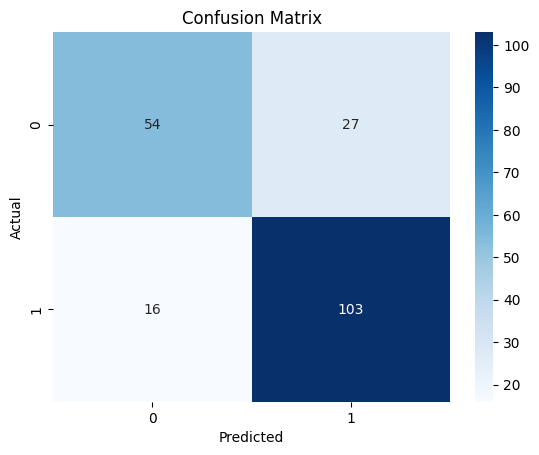

<Figure size 640x480 with 0 Axes>

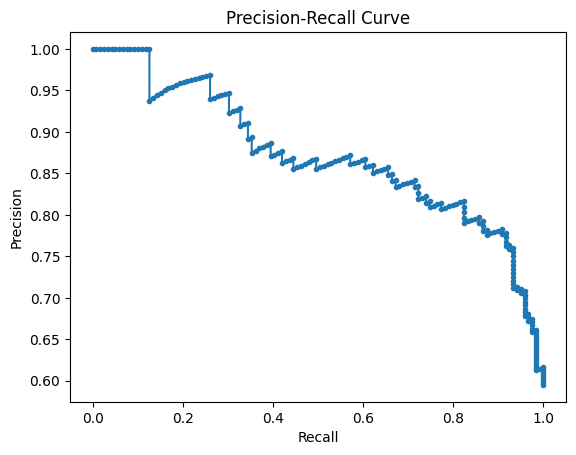

<Figure size 640x480 with 0 Axes>

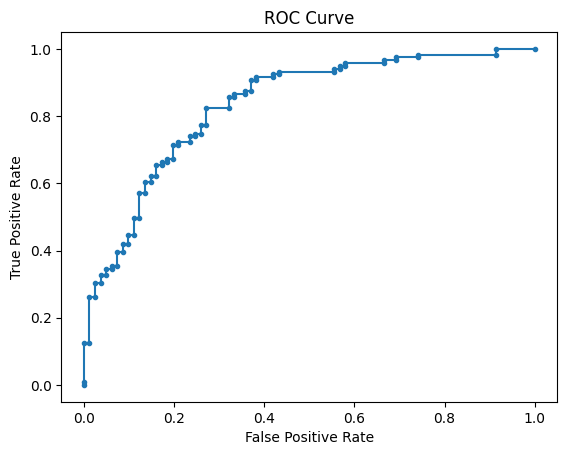

<Figure size 640x480 with 0 Axes>

In [ ]:
mlp_model = MLPClassifier(random_state=0)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': np.linspace(0.001, 0.1, 50),  # Fix learning rate range
    'max_iter': [200, 300, 400]
}

import random

num_iterations = 2
for i in range(num_iterations):
    hyperparams = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"Iteration {i+1}/{num_iterations}")
    print("Hyperparameters:", hyperparams)
    scaler = run_experiment(train=training_data, test=testing_data, model=mlp_model, hyperparams=hyperparams)

# Model Deployment

In [21]:
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.pyfunc import load_model

def get_best_model(metric="test_f1", experiment_name="Final Classification Experiment"):
    """
    Retrieves the best model from the specified MLflow experiment based on the given metric.
    
    Args:
        metric (str): The metric to base the selection on (default is "test_f1").
        experiment_name (str): The name of the MLflow experiment.
    
    Returns:
        dict: Information about the best run and the loaded model.
    """
    client = MlflowClient()
    
    # Get the experiment ID by name
    experiment = client.get_experiment_by_name(experiment_name)
    if not experiment:
        raise ValueError(f"Experiment '{experiment_name}' not found.")
    
    # Search runs within the experiment
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=[f"metrics.{metric} DESC"],
        max_results=1
    )
    
    if not runs:
        raise ValueError(f"No runs found in experiment '{experiment_name}' with metric '{metric}'.")
    
    best_run = runs[0]
    best_metric = best_run.data.metrics.get(metric, None)
    
    # Extract model URI and load the model
    model_uri = f"runs:/{best_run.info.run_id}/model"
    model = load_model(model_uri)
    
    print(f"Best model found in experiment '{experiment_name}' with {metric}={best_metric}, run_id={best_run.info.run_id}")
    return {"model": model, "run_id": best_run.info.run_id, "metric": best_metric}

In [22]:
best_model_info = get_best_model(metric="f1_test", experiment_name="Final Classification Experiment")
print(best_model_info)

Best model found in experiment 'Final Classification Experiment' with f1_test=0.9, run_id=bbad56782dfe4f74895a2b83724d2f94
{'model': mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: bbad56782dfe4f74895a2b83724d2f94
, 'run_id': 'bbad56782dfe4f74895a2b83724d2f94', 'metric': 0.9}


In [23]:
import mlflow.pyfunc
run_id = best_model_info['run_id']
try:
    model = mlflow.pyfunc.load_model(f"mlruns/378942515273578714/{run_id}/artifacts/model")
    success = True
except Exception as e:
    print(f"An error occurred: {e}")
    success = False

In [7]:
import subprocess

def serve_model(run_id, port):
    cmd = [
        "mlflow", "models", "serve",
        "-m", f"mlruns/378942515273578714/{run_id}/artifacts/model",
        "--port", str(port), "--env-manager=local"
    ]
    print("Running command:", " ".join(cmd))
    subprocess.Popen(cmd)

serve_model(run_id, 5002)

Running command: mlflow models serve -m mlruns/378942515273578714/06eaea49d56a41da8fc0ad505da05b8d/artifacts/model --port 5002 --env-manager=local


2024/12/09 18:36:14 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/12/09 18:36:14 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 127.0.0.1:5002 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2024-12-09 18:36:14 -0600] [76412] [INFO] Starting gunicorn 23.0.0
[2024-12-09 18:36:14 -0600] [76412] [INFO] Listening at: http://127.0.0.1:5002 (76412)
[2024-12-09 18:36:14 -0600] [76412] [INFO] Using worker: sync
[2024-12-09 18:36:14 -0600] [76413] [INFO] Booting worker with pid: 76413


In [26]:
import requests
import pandas as pd

def format_and_invoke(df, scaler, endpoint="http://127.0.0.1:5001/invocations"):
    continuous_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[continuous_columns] = scaler.transform(df[continuous_columns])
    df = df.apply(pd.to_numeric, errors='coerce')
    payload = {
        "dataframe_split": {
            "columns": df.columns.tolist(),
            "data": df.values.tolist()
        }
    }
    response = requests.post(endpoint, json=payload)
    return response

response = format_and_invoke(x_test, scaler)
print(response.json())

{'predictions': [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]}


In [31]:
# Load the dataset version v2
train, test = load_data_version('v1')
x_test = test.drop(columns=['Brain Rot'])
y_test = test['Brain Rot']


# Get the metrics using the best model
response = format_and_invoke(x_test, scaler)
accuracy, precision, recall, f1, roc_auc = classification_metrics(y_test,np.array(response.json()['predictions']))

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


M       data/

Accuracy: 0.8800
Precision: 0.8926
Recall: 0.9076
F1 Score: 0.9000
ROC AUC: 0.8735


In [32]:
# Load the dataset version v2
train, test = load_data_version('v2')
x_test = test.drop(columns=['Brain Rot'])
y_test = test['Brain Rot']


# Get the metrics using the best model
response = format_and_invoke(x_test, scaler)
accuracy, precision, recall, f1, roc_auc = classification_metrics(y_test,np.array(response.json()['predictions']))

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


M       data/

Accuracy: 0.8800
Precision: 0.8926
Recall: 0.9076
F1 Score: 0.9000
ROC AUC: 0.8735


# Model Monitoring

In [ ]:
# Get current data and reference data

# Load the dataset version v1
train, test = load_data_version('v1')
x_test = test.drop(columns=['Brain Rot'])
y_test = test['Brain Rot']



In [ ]:
import os
from evidently.report import Report
from evidently.metrics import DataDriftTable, RegressionPerformanceMetrics
from evidently import ColumnMapping

column_mapping = ColumnMapping(
    target="TARGET_deathRate",  
    prediction="predictions"  
)

reference_data = test
current_data = 

# These might have gotten set during previous iterations
if 'predictions' in current_data.columns:
    current_data.drop('predictions', axis=1, inplace=True)
    
if 'predictions' in reference_data.columns:
    reference_data.drop('predictions', axis=1, inplace=True)

current_data["predictions"] = xgb_model.predict(test_A.drop('TARGET_deathRate', axis=1))
reference_data['predictions'] = xgb_model.predict(test.drop('TARGET_deathRate', axis=1))

# Show the report in the Jupyter Notebook
report = Report(metrics=[
    DataDriftTable(), 
    RegressionPerformanceMetrics()
])
report.run(reference_data=reference_data, current_data=current_data, column_mapping=column_mapping)
os.makedirs(cwd / 'reports', exist_ok=True)
report.save_html(str(cwd / 'reports' / 'report_A.html'))
report.show()

ModuleNotFoundError: No module named 'evidently'

In [36]:
!pip install evidently

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached litestar-2.13.0-py3-none-any.whl.metadata (107 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached watchdog-6.0.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (44 kB)
  Using cached dynaconf-3.2.6-py2.py3-none-any.whl.metadata (9.1 kB)
  Using cached ujson-5.10.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (9.3 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached uuid6-2024.7.10-py3-none-any.whl.metadata (8.6 kB)
  Using cached msgspec-0.18.6-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 733.7 kB/s eta 0:00:001m677.2 kB/s eta 0:00:01
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached mypy_extensions-1.0.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached h11-0.14.0-py3-none-any.whl.met